<a href="https://colab.research.google.com/github/younesabdolmalaky/image-classification-on-rafdb-using-transfer-learning/blob/main/rafdb_Inceptionresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tanishmittal/rafdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 38.0M/38.2M [00:03<00:00, 18.3MB/s]
100% 38.2M/38.2M [00:03<00:00, 11.6MB/s]


In [2]:
! unzip /content/rafdb.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/aligned/train/train_images/train_07274_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07275_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07276_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07277_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07278_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07279_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07280_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07281_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07282_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07283_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07284_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07285_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07286_a

In [3]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import glob
from tensorflow import keras
from keras.layers.core import Dense 
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import callbacks
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [4]:
df = pd.read_csv('/content/dataset/train_labels.csv')
df.head()

,image,label
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5


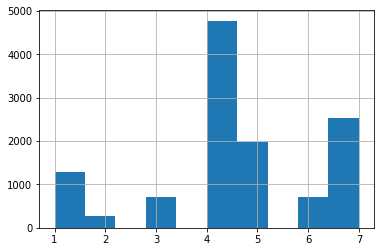

In [5]:
df['label'].hist()

In [6]:
input_tensor = tf.keras.Input(shape=(100, 100, 3))

In [7]:
train_csv = pd.read_csv('/content/dataset/train_labels.csv')
test_csv = pd.read_csv('/content/dataset/test_labels.csv')
train_csv['label'] = train_csv['label'].astype(str)
test_csv['label'] = test_csv['label'].astype(str)

In [8]:
datagen_train=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train_generator=datagen_train.flow_from_dataframe(
dataframe=train_csv,
directory='/content/dataset/aligned/train/train_images' , 
x_col="image",
y_col="label",
batch_size=64,
color_mode='rgb',
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(100,100))

datagen_test=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator=datagen_test.flow_from_dataframe(
dataframe=test_csv,
directory="/content/dataset/aligned/test/test_images",
x_col="image",
y_col="label",
batch_size=64,
seed=42,
color_mode='rgb',
shuffle=True,
class_mode="categorical",
target_size=(100,100))

Found 12271 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.


In [9]:
img_width, img_height = 100, 100

input_tensor = tf.keras.Input(shape=(img_width, img_height, 3))
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(base_model.input, output)

219055592/219055592 [==============================] - 11s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [11]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'binary_accuracy'])


In [12]:
mch = callbacks.ModelCheckpoint('/fianl-model.h5' , monitor='val_loss' , mode ='min' , save_best_only=True)

In [13]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train_generator.labels),y = train_generator.labels)
class_weights = {i : class_weights[i] for i in range(7)}


In [14]:
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=test_generator, validation_steps=len(test_generator)  , class_weight = class_weights, callbacks =[mch])


Epoch 1/100
192/192 [==============================] - 134s 292ms/step - loss: 0.3767 - precision: 0.6251 - recall: 0.1792 - binary_accuracy: 0.8674 - val_loss: 0.5935 - val_precision: 0.5883 - val_recall: 0.4299 - val_binary_accuracy: 0.8756
Epoch 2/100
192/192 [==============================] - 49s 252ms/step - loss: 0.2717 - precision: 0.7089 - recall: 0.5150 - binary_accuracy: 0.9005 - val_loss: 0.5136 - val_precision: 0.7069 - val_recall: 0.5968 - val_binary_accuracy: 0.9071
Epoch 3/100
192/192 [==============================] - 48s 249ms/step - loss: 0.2169 - precision: 0.7610 - recall: 0.6444 - binary_accuracy: 0.9203 - val_loss: 0.2083 - val_precision: 0.7453 - val_recall: 0.6838 - val_binary_accuracy: 0.9214
Epoch 4/100
192/192 [==============================] - 45s 235ms/step - loss: 0.1878 - precision: 0.7930 - recall: 0.7087 - binary_accuracy: 0.9320 - val_loss: 0.2123 - val_precision: 0.7714 - val_recall: 0.7040 - val_binary_accuracy: 0.9279
Epoch 5/100
192/192 [==========